# <font color=red><center>**My Content : Books recommandation app**</center></font>

# <font color=red><center>**Content-based Filtering with Scikit-Learn**</font>

## **<font color=green>The project</font>**
"My Content" is a start-up who's goal is to encourage people to read by recommending relevant content to users.

In this project, we want to create a first MVP that will take the form of an application that will be recommend relevant articles to users based on their implicit preferences, their profiles and the articles content. This is known as a Recommender System. Thus, we will complete the following tasks: 

* We will compare different models of recommender system on the Globo.com dataset. 

* We will use Azure Functions to store the recommendations in Azure CosmosDB and to make the recommendations available to the users.

* We will integrate that Azure Functions into a Streamlit App that will be able to recommend relevant articles to users. 

**In ths notebook, we compute a simple cosine similarity between user interests and item features.**

## **<font color=green>Dataset</font>**
We will work with the Globo.com 

The dataset is composed of the following files :

- clicks/clicks/ : contains 385 CSV files
- clicks_hour_*.csv : contains one hour of clicks on the website
- articles_embeddings.pickle : pickle file containing the embeddings of the articles
- articles_metadata.csv : CSV file containing the metadata of the articles

# <font color=salmon>PART 1 - LIBRARIES, PARAMETERS</font>

## **<font color=green>Loading libraries</font>**

In [1]:
import logging
import random
from datetime import datetime
from pathlib import Path

import numpy as np
import pandas as pd
import plotly.express as px
from pandas.api.types import is_numeric_dtype
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

pd.options.plotting.backend = "plotly"


RAW_DATA_PATH = "../data"

CACHE = dict()

In [2]:
NUM_EMBEDDINGS = 250

articles = pd.concat(
    [
        pd.read_csv(
            Path(RAW_DATA_PATH, "articles_metadata.csv"),
            parse_dates=["created_at_ts"],
            date_parser=lambda x: datetime.fromtimestamp(int(x) / 1000),
            dtype={
                "article_id": "category",
                "category_id": "category",
                "publisher_id": "category",
                "words_count": "int",
            },
        ),
        pd.DataFrame(
            pd.read_pickle(Path(RAW_DATA_PATH, "articles_embeddings.pickle")),
            columns=["embedding_" + str(i) for i in range(NUM_EMBEDDINGS)],
        ),
    ],
    axis=1,
)

articles = articles.astype({"created_at_ts": "datetime64[ns]"})

articles_sample = articles.sample(frac=0.01, random_state=42)

articles.describe(include="all", datetime_is_numeric=True)

,article_id,category_id,created_at_ts,publisher_id,words_count,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,...,embedding_240,embedding_241,embedding_242,embedding_243,embedding_244,embedding_245,embedding_246,embedding_247,embedding_248,embedding_249
count,364047,364047,364047,364047,364047.000000,364047.000000,364047.000000,364047.000000,364047.000000,364047.000000,...,364047.000000,364047.000000,364047.000000,364047.000000,364047.000000,364047.000000,364047.000000,364047.000000,364047.000000,364047.000000
unique,364047,461,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,0,281,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,12817,NaN,364047,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,2016-09-17 01:25:54.949498624,NaN,190.897727,-0.238645,-0.963335,0.118548,-0.279295,-0.068579,...,-0.133287,-0.081912,-0.060347,0.023003,0.076947,0.084603,0.062819,0.099768,0.155917,-0.041094
min,NaN,NaN,2006-09-27 13:14:35,NaN,0.000000,-0.991183,-0.996455,-0.968431,-0.994966,-0.994489,...,-0.990412,-0.989408,-0.990432,-0.993626,-0.989042,-0.996902,-0.992921,-0.984733,-0.976071,-0.988213
25%,NaN,NaN,2015-10-15 18:00:43.500000,NaN,159.000000,-0.620072,-0.974056,-0.289953,-0.718816,-0.503425,...,-0.547684,-0.445079,-0.479989,-0.404508,-0.248653,-0.267072,-0.306548,-0.313598,-0.201402,-0.420694
50%,NaN,NaN,2017-03-13 17:27:29,NaN,186.000000,-0.302581,-0.967605,0.124339,-0.391535,-0.093734,...,-0.175781,-0.094113,-0.078034,0.000726,0.105649,0.133525,0.083315,0.128757,0.188355,-0.015232
75%,NaN,NaN,2017-11-05 15:09:11,NaN,218.000000,0.098015,-0.959061,0.545112,0.108320,0.345024,...,0.250641,0.270006,0.341105,0.459386,0.417347,0.461466,0.441831,0.531453,0.538111,0.334226
max,NaN,NaN,2018-03-13 13:12:30,NaN,6690.000000,0.983694,-0.514728,0.998341,0.978092,0.996798,...,0.996401,0.981789,0.991332,0.995299,0.978823,0.989324,0.991445,0.997583,0.990507,0.968462


In [4]:
clicks = pd.concat(
    [
        pd.read_csv(
            click_file_path,
            parse_dates=["session_start", "click_timestamp"],
            date_parser=lambda x: datetime.fromtimestamp(int(int(x) / 1000)),
            dtype={
                "user_id": "category",
                "session_id": "category",
                "session_size": "int",
                "click_article_id": "category",
                "click_environment": "category",
                "click_deviceGroup": "category",
                "click_os": "category",
                "click_country": "category",
                "click_region": "category",
                "click_referrer_type": "category",
            })
       
        for click_file_path in tqdm(
            sorted(Path(RAW_DATA_PATH, "clicks/clicks").glob("clicks_hour_*.csv"))
        )
    ],
    sort=False,
    ignore_index=True,
    verify_integrity=True,
)

clicks = clicks.astype(
    {"session_start": "datetime64[ns]", "click_timestamp": "datetime64[ns]"}
)

clicks.describe(include="all", datetime_is_numeric=True)

100%|████████████████████████████████████████████████████████████████████████████████| 385/385 [00:34<00:00, 11.25it/s]


,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
count,2988181,2988181,2988181,2.988181e+06,2988181,2988181,2988181,2988181,2988181,2988181,2988181,2988181
unique,322897,1048594,NaN,NaN,46033,NaN,3,5,8,11,28,7
top,5890,1507563657895091,NaN,NaN,160974,NaN,4,1,17,1,25,2
freq,1232,124,NaN,NaN,37213,NaN,2904478,1823162,1738138,2852406,804985,1602601
mean,NaN,NaN,2017-10-08 16:17:08.013155328,3.901885e+00,NaN,2017-10-08 16:51:05.070374400,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,2017-10-01 04:37:03,2.000000e+00,NaN,2017-10-01 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,2017-10-04 15:35:52,2.000000e+00,NaN,2017-10-04 16:20:52,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,2017-10-08 22:09:00,3.000000e+00,NaN,2017-10-08 22:35:30,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,2017-10-11 21:16:54,4.000000e+00,NaN,2017-10-11 21:43:24,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,2017-10-17 05:36:19,1.240000e+02,NaN,2017-11-13 21:04:14,NaN,NaN,NaN,NaN,NaN,NaN


### Models for user's preferences

We tested 3 different models to check user's preferences
* Last-clicked article
* Average of user's clicked articles over last session
* Average of all clicked articles

In [10]:
def aggregate_articles(articles):
    return articles.groupby(lambda x: True).agg(
        {
            col: "mean"
            if is_numeric_dtype(articles.dtypes[col])
            else lambda x: x.mode()[0]
            for col in articles.columns
        }
    )


def get_user_interest(user_id, clicks, articles, strategy="last_click"):
    user_id = str(user_id)

    if strategy == "last_click":
        last_clicked_article_id = (
            clicks.query("user_id == @user_id")
            .sort_values("click_timestamp", ascending=False)
            .reset_index(drop=True)
            .iloc[0]["click_article_id"]
        )
        interest = articles.query("article_id == @last_clicked_article_id")

    elif strategy == "last_session":
        last_session_id = (
            clicks.query("user_id == @user_id")
            .sort_values("click_timestamp", ascending=False)
            .reset_index(drop=True)
            .iloc[0]["session_id"]
        )
        session_article_ids = clicks.query("session_id == @last_session_id")[
            "click_article_id"
        ]
        interest = aggregate_articles(
            articles.query("article_id in @session_article_ids")
        ).drop(["article_id"], axis=1)

    elif strategy == "all_clicks":
        all_article_ids = clicks.query("user_id == @user_id")["click_article_id"]
        interest = aggregate_articles(
            articles.query("article_id in @all_article_ids")
        ).drop(["article_id"], axis=1)

    else:
        raise NotImplementedError

    return interest


def prepare_for_scale(articles, category_id):
    articles_copy = articles.drop(["article_id", "similarity"], axis=1, errors="ignore")
    articles_copy["category_id"] = articles_copy["category_id"].apply(
        lambda x: category_id if int(x) == category_id else 0
    )
    articles_copy["created_at_ts"] = articles_copy["created_at_ts"].apply(
        lambda x: x.value
    )

    return articles_copy


def get_closest_articles(interest, articles, n=5):
    category_id = interest["category_id"].iloc[0]

    scaler = StandardScaler()
    articles_std = scaler.fit_transform(prepare_for_scale(articles, category_id))
    interest_std = scaler.transform(prepare_for_scale(interest, category_id))

    articles = articles.copy()
    articles["similarity"] = cosine_similarity(interest_std, articles_std)[0]

    return (
        articles.sort_values("similarity", ascending=False).iloc[:n],
        scaler,
        articles_std,
        interest_std,
    )

In [11]:
clicks["user_id"][11183]

'4079'

In [12]:
user_id = "11183"

interest = get_user_interest(user_id, clicks, articles, strategy="all_clicks")
category_id = interest["category_id"].iloc[0]

closest_articles, scaler, articles_std, interest_std = get_closest_articles(
    interest, articles
)

articles_sample_std = scaler.transform(prepare_for_scale(articles_sample, category_id))
closest_articles_std = scaler.transform(
    prepare_for_scale(closest_articles, category_id)
)

closest_articles.head()

,article_id,category_id,created_at_ts,publisher_id,words_count,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,...,embedding_241,embedding_242,embedding_243,embedding_244,embedding_245,embedding_246,embedding_247,embedding_248,embedding_249,similarity
206332,206332,331,2017-08-08 07:00:59,0,226,0.025988,-0.954635,0.336524,0.625055,-0.548869,...,0.483356,0.638636,-0.362254,0.008738,0.898286,-0.377594,0.822733,-0.275243,-0.074718,0.813665
206122,206122,331,2017-08-07 07:00:59,0,236,0.060776,-0.966598,0.135507,0.670903,-0.670378,...,0.633938,0.621593,-0.332491,-0.033522,0.777436,-0.179254,0.788831,-0.156612,0.297471,0.810633
149706,149706,276,2017-10-12 08:45:51,0,414,-0.412028,-0.974531,0.430597,0.620538,-0.237067,...,0.623956,0.850811,-0.697986,0.419209,0.860569,-0.618595,0.906938,0.004666,0.146258,0.810386
61369,61369,126,2017-08-06 08:00:04,0,377,-0.507175,-0.965842,-0.067460,0.503145,-0.727862,...,0.428090,0.705584,-0.492077,0.176457,0.735492,-0.606399,0.831116,-0.129371,0.089162,0.806339
206670,206670,331,2017-05-18 01:23:20,0,333,-0.349059,-0.978512,0.449308,0.685235,-0.633160,...,0.421061,0.765930,-0.800000,0.218453,0.788560,-0.286604,0.869114,-0.193989,0.369351,0.800472


#### Dimensionallity reduction

We used two methods to reduce the dimensionality of the data, Principal Component Analysis (PCA), and t-Distributed Stochastic Neighbor Embedding (t-SNE).
* **PCA** (essentially) maps data onto a plane of a lower dimension, preserving the distances between the datapoints. The orientation of the lower dimensional plane is chosen to reflect the structure of the higher dimensional data.

* **t-SNE** is a non-linear algorithm which considers the similarity of different objects, and uses this to decide on their distance in the 2D (or 3D) plane. A probability distribution (where similar objects have a high chance of being picked) is used to gauge the similarity of objects, and then plots the points on a lower dimension so that the probability distribution is similar to in the higher plane.


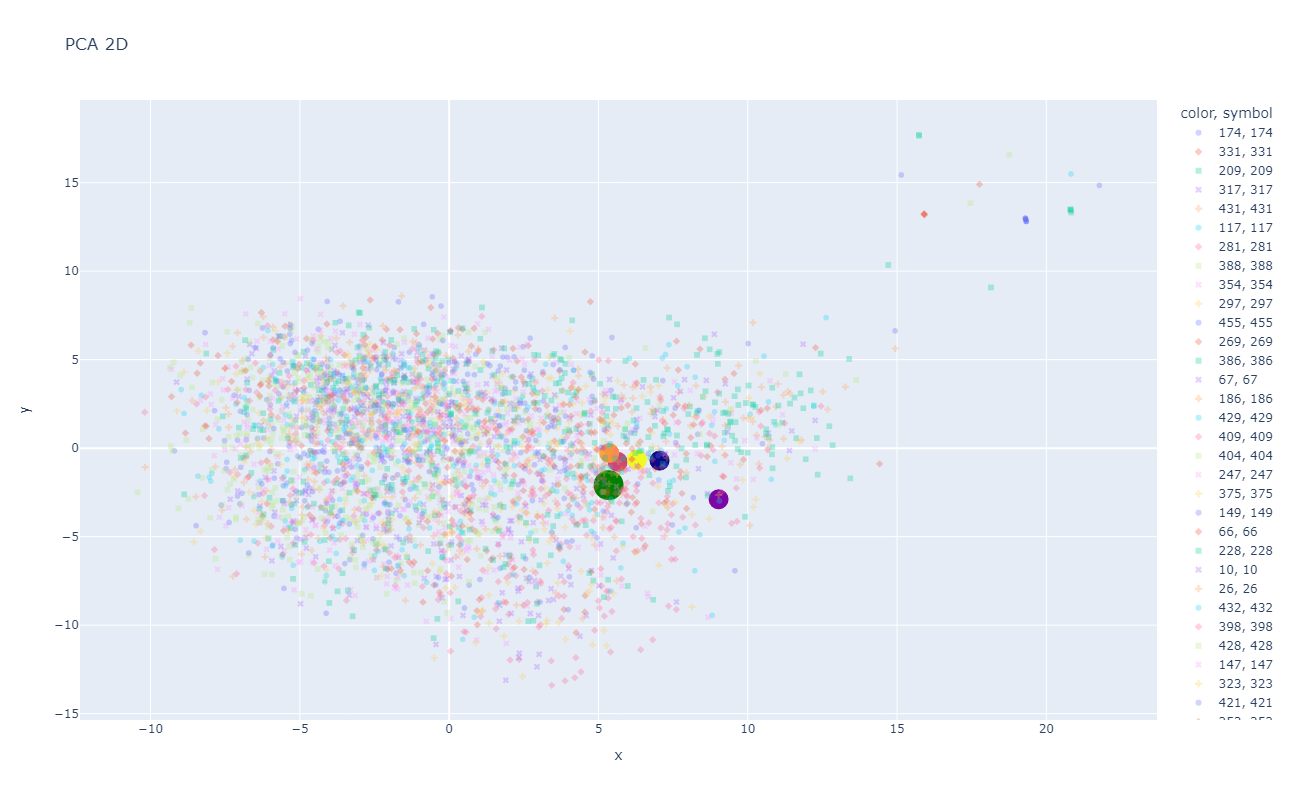

In [13]:
pca = PCA(n_components=2)
articles_pca = pca.fit_transform(articles_sample_std)
interest_pca = pca.transform(interest_std)
closest_articles_pca = pca.transform(closest_articles_std)


# Plot the data in the PCA space
fig = px.scatter(
    x=articles_pca[:, 0],
    y=articles_pca[:, 1],
    color=articles_sample["category_id"],
    symbol=articles_sample["category_id"],
    title="PCA 2D",
    opacity=0.3,
    width=1200,
    height=800,
)
fig.add_scatter(
    x=interest_pca[:, 0],
    y=interest_pca[:, 1],
    mode="markers",
    marker=dict(color="green", size=30),
    text=f"User interest \n user_id: {user_id} \n category_id: {interest['category_id'].iloc[0]}",
)
fig.add_scatter(
    x=closest_articles_pca[:, 0],
    y=closest_articles_pca[:, 1],
    mode="markers",
    marker=dict(color=list(range(len(closest_articles_pca))), size=20),
    text=[
        f"rank: {i} / article_id: {a.article_id} / category_id: {a.category_id}"
        for i, a in enumerate(closest_articles.itertuples())
    ],
)
fig.show()

C:\Users\ezequ\miniconda3\envs\gpu7\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

C:\Users\ezequ\miniconda3\envs\gpu7\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



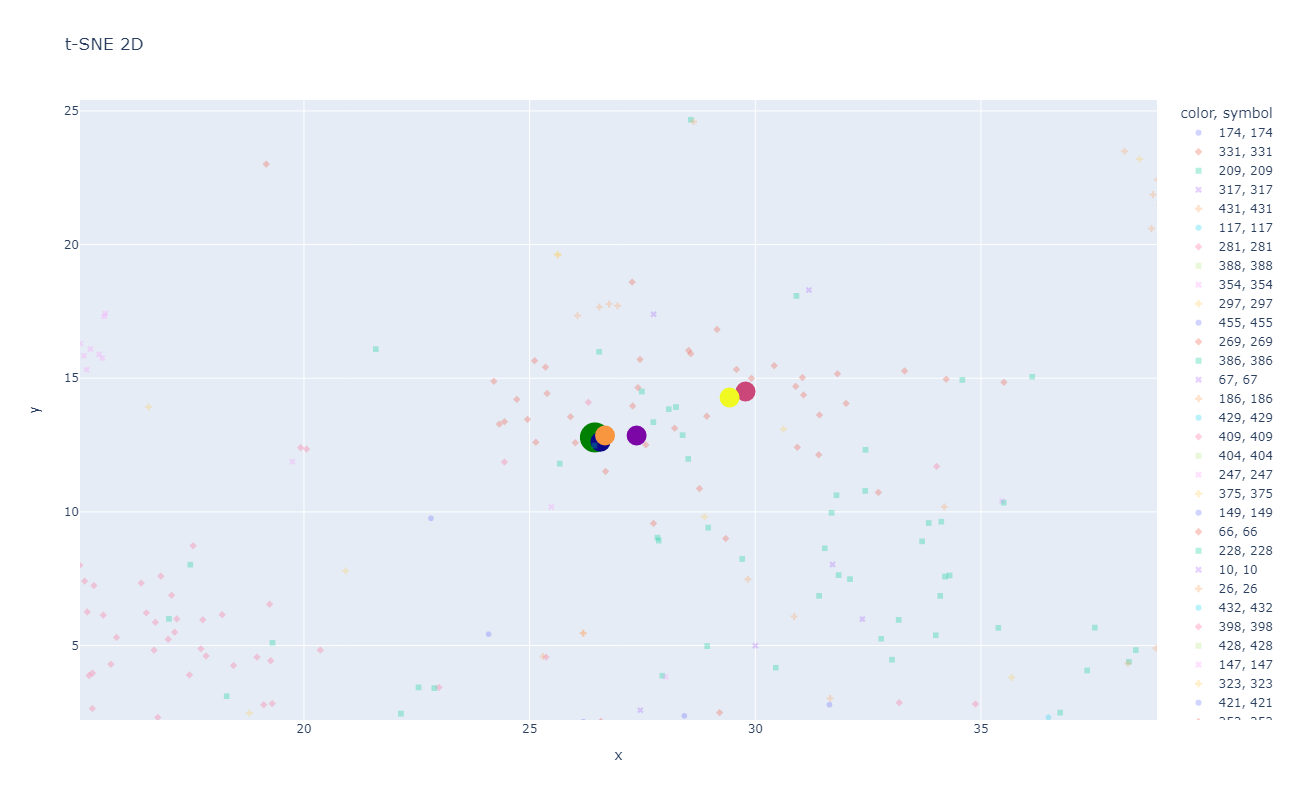

In [14]:
tsne = TSNE(n_components=2)
articles_tsne = tsne.fit_transform(
    np.concatenate((articles_sample_std, closest_articles_std, interest_std))
)

interest_tsne = articles_tsne[-1:]
articles_tsne = articles_tsne[:-1]

closest_articles_tsne = articles_tsne[-len(closest_articles) :]
articles_tsne = articles_tsne[: -len(closest_articles)]


# Plot the data in the t-SNE space
fig = px.scatter(
    x=articles_tsne[:, 0],
    y=articles_tsne[:, 1],
    color=articles_sample["category_id"],
    symbol=articles_sample["category_id"],
    title="t-SNE 2D",
    opacity=0.3,
    width=1200,
    height=800,
)
fig.add_scatter(
    x=interest_tsne[:, 0],
    y=interest_tsne[:, 1],
    mode="markers",
    marker=dict(color="green", size=30),
    text=f"User interest \n user_id: {user_id} \n category_id: {interest['category_id'].iloc[0]}",
)
fig.add_scatter(
    x=closest_articles_tsne[:, 0],
    y=closest_articles_tsne[:, 1],
    mode="markers",
    marker=dict(color=list(range(len(closest_articles_tsne))), size=20),
    text=[
        f"rank: {i} / article_id: {a.article_id} / category_id: {a.category_id}"
        for i, a in enumerate(closest_articles.itertuples())
    ],
)
fig.show()

### Train the model

In [19]:
users_last_click = (
    clicks.reset_index()
    .rename(columns={"index": "click_id"})
    .sort_values(by="click_timestamp")
    .groupby(["user_id"])
    .last()
)

X = clicks.drop(list(users_last_click["click_id"]))
y_true = dict(users_last_click["click_article_id"])

test_sample = random.sample(list(y_true.keys()), k=100)

In [20]:
y_pred_last_click = {
    user_id: list(
        get_closest_articles(
            get_user_interest(user_id, X, articles, strategy="last_click"),
            articles,
            n=1000,
        )[0]["article_id"]
    )
    for user_id in tqdm(test_sample)
}

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [29:28<00:00, 17.68s/it]


In [21]:
y_pred_last_session = {
    user_id: list(
        get_closest_articles(
            get_user_interest(user_id, X, articles, strategy="last_session"),
            articles,
            n=1000,
        )[0]["article_id"]
    )
    for user_id in tqdm(test_sample)
}

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [29:04<00:00, 17.45s/it]


In [22]:
y_pred_all_clicks = {
    user_id: list(
        get_closest_articles(
            get_user_interest(user_id, X, articles, strategy="all_clicks"),
            articles,
            n=1000,
        )[0]["article_id"]
    )
    for user_id in tqdm(test_sample)
}

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [30:35<00:00, 18.36s/it]


### Define Score to measure the model

In [23]:
def score_reco(y_true, y_pred):
    score = 0
    count = 0
    for user_id, pred_article_ids in y_pred.items():
        if user_id not in y_true.keys():
            logging.info(f"User {user_id} not found in true values")
            continue

        true_article_id = str(y_true[user_id])

        if true_article_id not in pred_article_ids:
            logging.info(
                f"Article {true_article_id} not found in predictions for user {user_id}"
            )
            continue

        rank = pred_article_ids.index(true_article_id) + 1
        score += 1 / rank
        count += 1

    # In range [0 , 1], higher is better
    return score / count


def mean_rank(y_true, y_pred):
    sum = 0
    count = 0
    for user_id, pred_article_ids in y_pred.items():
        if user_id not in y_true.keys():
            logging.info(f"User {user_id} not found in true values")
            continue

        true_article_id = str(y_true[user_id])

        if true_article_id not in pred_article_ids:
            logging.info(
                f"Article {true_article_id} not found in predictions for user {user_id}"
            )
            continue

        rank = pred_article_ids.index(true_article_id) + 1
        sum += rank
        count += 1

    # In range [1 , +Inf], lower is better
    return sum / count


def mean_average_precision(y_true, y_pred, articles, k=10):
    average_precision = 0
    for user_id, pred_article_ids in y_pred.items():
        if user_id not in y_true.keys():
            logging.warning(f"User {user_id} not found in true values")
            continue

        true_category_id = articles.iloc[int(y_true[user_id])].category_id
        pred_categories = articles.iloc[
            [int(id) for id in pred_article_ids[:k]]
        ].category_id

        average_precision = (
            len(pred_categories[pred_categories == true_category_id]) / k
        )

    return average_precision / len(y_pred)

### Results

In [24]:
print(f"Score : {score_reco(y_true, y_pred_last_click)}")
print(f"Mean Rank : {mean_rank(y_true, y_pred_last_click)}")
print(
    f"Mean Average Precision : {mean_average_precision(y_true, y_pred_last_click, articles, k=1000)}"
)

Score : 0.06428996721559138
Mean Rank : 169.88888888888889
Mean Average Precision : 8.999999999999999e-05


In [25]:
print(f"Score : {score_reco(y_true, y_pred_last_session)}")
print(f"Mean Rank : {mean_rank(y_true, y_pred_last_session)}")
print(
    f"Mean Average Precision : {mean_average_precision(y_true, y_pred_last_session, articles, k=1000)}"
)

Score : 0.05165544117367384
Mean Rank : 204.44444444444446
Mean Average Precision : 8.999999999999999e-05


In [26]:
print(f"Score : {score_reco(y_true, y_pred_all_clicks)}")
print(f"Mean Rank : {mean_rank(y_true, y_pred_all_clicks)}")
print(
    f"Mean Average Precision : {mean_average_precision(y_true, y_pred_all_clicks, articles, k=1000)}"
)

Score : 0.059834521273234687
Mean Rank : 309.57142857142856
Mean Average Precision : 0.00013
